In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neighbors import KernelDensity 

import torch
import torch.nn as nn
from torch.optim import Adam

In [2]:
class InvertibleLayer(nn.Module):
    def __init__(self, size_z, size_hidden, mask):
        super(InvertibleLayer, self).__init__()
        
        self.size_z = size_z
        self.size_hidden = size_hidden

        self.s = nn.Sequential(
            nn.Linear(self.size_z, self.size_hidden),
            nn.ELU(), 
            nn.Linear(self.size_hidden, self.size_hidden),
            nn.ELU(),
            nn.Linear(self.size_hidden, self.size_z),
        )
        
        self.t = nn.Sequential(
            nn.Linear(self.size_z, self.size_hidden),
            nn.ELU(), 
            nn.Linear(self.size_hidden, self.size_hidden),
            nn.ELU(),
            nn.Linear(self.size_hidden, self.size_z),
        )

        self.mask = mask[None,:]

    def forward(self, z):
        z_mask = z*self.mask
        s = self.s(z_mask)
        t = self.t(z_mask)
        x = z_mask + (1 - self.mask) * (z*torch.exp(s) + t)

        log_det_jac = ((1 - self.mask) * s).sum(-1)
        return x, log_det_jac
       

    def inverse(self, x):
        x_mask = x*self.mask
        s = self.s(x_mask)
        t = self.t(x_mask)
        z = x_mask + (1 - self.mask) * (x-t)*torch.exp(-s)

        inv_log_det_jac = ((1 - self.mask) * -s).sum(-1)
        return z, inv_log_det_jac

    def check_invertibility(self, n_samples):
        z = torch.randn(n_samples,self.size_z)
        print('Invertibility of layer s.t. z==T^{-1}(T(z)):', torch.allclose(z,self.inverse(self.forward(z)[0])[0]))

In [3]:
class NormalizingFlow(nn.Module):
    def __init__(self, n_layers, size_z, size_hidden, masks, prior):
        super(NormalizingFlow, self).__init__()
        self.device = masks.device 
        
        self.layers = nn.ModuleList()
        for layer in range(n_layers):
            self.layers.append(InvertibleLayer(size_z=size_z, size_hidden=size_hidden, mask=masks[layer]))
        self.prior_mu, self.prior_sigma = prior[0], prior[1] 

    def log_multivariate(self, tmp):
        return -0.5*(tmp**2).sum(-1)

    def backward(self, x):
        # sample x -> z, eval p(z)
        log_det = torch.zeros((x.shape[0])).to(x.device)
        for layer in self.layers:
            x, log_det_layer = layer.inverse(x)
            log_det += log_det_layer
        return x, log_det

    def forward(self, z):
        # sample z -> x, eval p(x)
        log_det = torch.zeros((z.shape[0])).to(z.device)
        for layer in reversed(self.layers):
            z, log_det_layer = layer(z)
            log_det += log_det_layer
            
        return z, log_det

    def log_pz_2DGauss(self, z):
        # evaluate log-pdf of prior distribution
        t1 = -np.log(2*np.pi) - 0.5*torch.linalg.slogdet(self.prior_sigma).logabsdet # constant terms 
        z_mu = z[:,:,None]-self.prior_mu[None,:,:]
        t2 = -0.5*torch.einsum('bjk,bj->bk',z_mu,torch.einsum('ij,bjk->bi',torch.linalg.inv(self.prior_sigma + 1e-6), z_mu))
        return t1 + t2

    def fit(self, x, max_iter, lr):
        optim = Adam(params=self.parameters(), lr=lr)
        self.train()
        
        loss_total, loss_pz, loss_log_det = [], [], []
        for iter_ in range(max_iter):
            z, sum_log_det = self.backward(x)
            
            log_pz = self.log_pz_2DGauss(z) # simple 2D gaussian for prior distribution
            loss = -log_pz.mean() - sum_log_det.mean() 

            optim.zero_grad()
            loss.backward()
            optim.step()

            loss_total.append(loss.item())
            loss_pz.append(-log_pz.mean().item())
            loss_log_det.append(-sum_log_det.mean().item())
    
            x = shuffle(x)
        
        return [loss_total, loss_pz, loss_log_det]
    
    def sample(self, n_samples):
        self.eval()
        L = torch.linalg.cholesky(self.prior_sigma)
        z_samples = self.prior_mu[None,:,0] + torch.einsum('ij,bj->bi', L, torch.randn(n_samples,2).to(self.device))
        x_samples, samples_log_det = self.forward(z_samples)
        return x_samples

torch.Size([2000, 2])


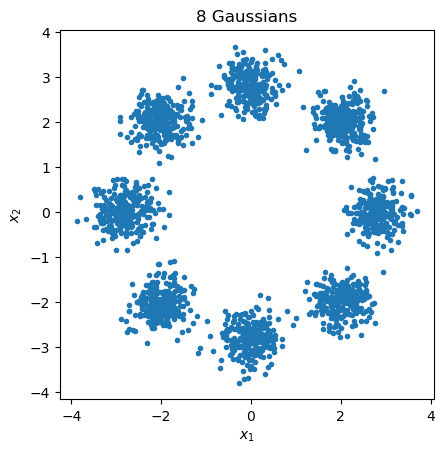

In [4]:
# generate data
n_samples = 2000
z = torch.randn(n_samples, 2)

sq = 1./np.sqrt(2)
fact = 4.*sq
mus = [fact*torch.Tensor([[1.],[0.]]), fact*torch.Tensor([[-1.],[0.]]), fact*torch.Tensor([[0.],[1.]]), fact*torch.Tensor([[0.],[-1.]]),\
    fact*torch.Tensor([[sq],[sq]]), fact*torch.Tensor([[-sq],[sq]]), fact*torch.Tensor([[sq],[-sq]]), fact*torch.Tensor([[-sq],[-sq]])]

sig = 0.1 * torch.Tensor([[1.,0.0],[0.0,1.]])
x_all = [mu + torch.linalg.cholesky(sig)@torch.randn(2,int(n_samples/8.)) for mu in mus]
x = torch.hstack(x_all).T
mus = torch.hstack(mus) # 2,8
print(x.shape)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal', 'box')
ax.scatter(x[:,0],x[:,1],marker='.'), plt.title('8 Gaussians')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [5]:
masks = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(4)])).float()
T1 = InvertibleLayer(size_z=2, size_hidden=16, mask=masks[0])
T1.check_invertibility(n_samples=3)

Invertibility of layer s.t. z==T^{-1}(T(z)): True


In [6]:
# settings
n_layers = 4
size_z = 2
size_hidden = 128 
lr = 5.0E-4
max_iter = 10000 

In [9]:
masks = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(n_layers)])).float().to(x.device)

# prior distribution to which flow should map
prior = [torch.zeros((2,1),device=x.device), torch.eye(2).to(x.device)]

normflow = NormalizingFlow(n_layers=n_layers, size_z=size_z, size_hidden=size_hidden, masks=masks, prior=prior)
normflow = normflow.to(x.device)

losses = normflow.fit(x,max_iter=max_iter,lr=lr)

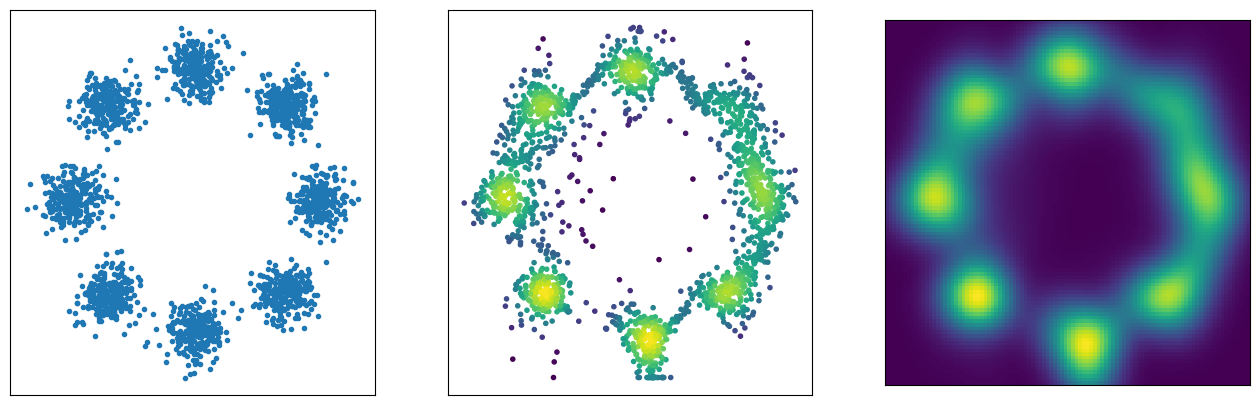

In [11]:
# sample from flow
samples = normflow.sample(n_samples=n_samples)
samples.detach_()
samples = torch.clamp(samples,x.min(),x.max())
kde = KernelDensity(bandwidth=.4).fit(samples.cpu().numpy())
samples_kde = np.exp(kde.score_samples(samples.cpu().numpy()))

# evaluate fitted density from KDE on entire data space
min_val, max_val = x.min(), x.max()
yy, xx = torch.meshgrid(torch.linspace(min_val,max_val,100),torch.linspace(min_val,max_val,100)) 
x_test = torch.stack((xx.ravel(),yy.ravel())).T.to(x.device)
density_x_test = np.exp(kde.score_samples(x_test.cpu().numpy()))

# plotting
fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].scatter(x[:,0].cpu(),x[:,1].cpu(),marker='.'), ax[0].set_xticks([]), ax[0].set_yticks([])
# plot estimated density
ax[1].scatter(samples[:,0].cpu(),samples[:,1].cpu(),c=samples_kde,marker='.'), ax[1].set_xticks([]), ax[1].set_yticks([])
# plot generated samples
ax[2].imshow(density_x_test.reshape(xx.shape[0],xx.shape[1]),origin='lower'), ax[2].set_xticks([]), ax[2].set_yticks([])
plt.savefig(os.getcwd() + '/out/nf.png', bbox_inches='tight')
plt.show()
    

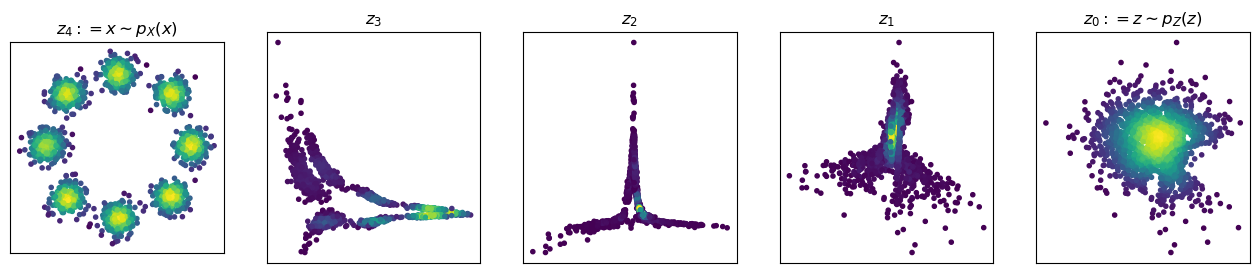

In [12]:
# plot transformed layers
fig, ax = plt.subplots(1,5,figsize=(16,3))
x_trans = x.clone()

# fit KDE at current layer
kde = KernelDensity(bandwidth=.4).fit(x_trans.cpu().numpy())
xx, yy = np.meshgrid(np.linspace(x.min().item(),x.max().item(),100),np.linspace(x.min().item(),x.max().item(),100))
x_grid = np.stack((xx.ravel(), yy.ravel()),1)
density = np.exp(kde.score_samples(x_grid))
samples_kde = np.exp(kde.score_samples(x_trans.cpu().numpy()))

ax[0].scatter(x_trans[:,0].detach().cpu().numpy(), x_trans[:,1].detach().cpu().numpy(),marker='.',c=samples_kde)
ax[0].set_title('$z_4 := x\sim p_X(x)$')
ax[0].set_aspect('equal')
ax[0].set_xticks([]), ax[0].set_yticks([])

for layer_idx, layer in enumerate(normflow.layers):
    x_trans, _ = layer.inverse(x_trans)
    x_trans.detach_()

    # fit KDE at current layer
    kde = KernelDensity(bandwidth=.4).fit(x_trans.cpu().numpy())
    xx, yy = np.meshgrid(np.linspace(x.min().item(),x.max().item(),100),np.linspace(x.min().item(),x.max().item(),100))
    x_grid = np.stack((xx.ravel(), yy.ravel()),1)
    density = np.exp(kde.score_samples(x_grid))
    samples_kde = np.exp(kde.score_samples(x_trans.cpu().numpy()))

    ax[layer_idx+1].scatter(x_trans[:,0].detach().cpu().numpy(), x_trans[:,1].detach().cpu().numpy(),marker='.',c=samples_kde)
    if layer_idx == len(normflow.layers) - 1:
        ax[layer_idx+1].set_title('$z_0 := z \sim p_Z(z)$')
    else:
        ax[layer_idx+1].set_title('$z_%i$' %(len(normflow.layers)-layer_idx - 1))
    ax[layer_idx+1].set_xticks([]), ax[layer_idx+1].set_yticks([])
plt.savefig(os.getcwd() + '/out/nf_layers.png', bbox_inches='tight', pad_inches=0)
plt.show()